In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [8]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [10]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Trend Following Signal

In [154]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("fast_mavg_log",                  fast_mavg_log),
            ("slow_mavg_log",                  slow_mavg_log),
            ("mavg_stepsize_log",              mavg_stepsize_log),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("rolling_donchian_window", rolling_donchian_window),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()


In [15]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [17]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [19]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [21]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [82]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [321]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                           donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # # Generate Trend Signal
    # df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
    #                                   slope_window=10, moving_avg_type=moving_avg_type,
    #                                   price_or_returns_calc=price_or_returns_calc)
    #             .rename(columns={
    #                 f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
    #                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # # Calculate Ribbon Slope and Z-Score
    # mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    # df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
    #     calc_ribbon_slope, 
    #     axis=1, 
    #     args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    # )

    # ## Calculate Trend Rank
    # ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    # ## slope near the origin takes into account even little information
    # df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    df_trend[[trend_continuous_signal_rank_col]] = (df_trend[[trend_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    # # Generate Donchian Channels
    # df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
    #                                           price_or_returns_calc=price_or_returns_calc,
    #                                           rolling_donchian_window=rolling_donchian_window,
    #                                           use_coinbase_data=use_coinbase_data)

    # # Donchian Buy signal: Price crosses above upper band
    # # Donchian Sell signal: Price crosses below lower band
    # df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    # t_1_close_col = f't_1_close'
    # donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    # donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    # donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    # df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    # df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    # df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    # df_donchian[donchian_binary_signal_col] = np.where(
    #     (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
    #     np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    # df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
    #                                                (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    # ## Calculate Donchian Channel Rank
    # ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    # ## slope near the origin takes into account even little information
    # df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # # Merging the Trend and Donchian Dataframes
    # donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
    #                  donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    # df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    # df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
    #     df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    # df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
    #                                                 donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])
    df_trend[final_weighted_additive_signal_col] = ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col]

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                            donchian_signal_weight, ma_crossover_signal_weight, 
                                            long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        print(ticker)
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, 
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [307]:
end_date_test = pd.Timestamp('2021-03-31').date()
ticker_list_mod = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date_test]

['BTC-USD', 'ETH-USD', 'MATIC-USD']

In [287]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'MATIC-USD', 'AVAX-USD']

In [291]:
date_list = cn.coinbase_start_date_by_ticker_dict
date_list

{'BTC-USD': '2016-01-01',
 'ETH-USD': '2016-06-01',
 'SOL-USD': '2021-06-01',
 'LTC-USD': '2016-09-01',
 'DOGE-USD': '2021-06-01',
 'CRO-USD': '2021-11-01',
 'ADA-USD': '2021-03-01',
 'AVAX-USD': '2021-09-01',
 'XRP-USD': '2023-06-01',
 'SHIB-USD': '2021-08-01',
 'LINK-USD': '2019-06-01',
 'UNI-USD': '2020-09-01',
 'DOT-USD': '2021-06-01',
 'FET-USD': '2021-07-01',
 'ALGO-USD': '2019-08-01',
 'DAI-USD': '2020-04-01',
 'AAVE-USD': '2020-12-01',
 'XLM-USD': '2019-02-01',
 'MATIC-USD': '2021-02-01',
 'ATOM-USD': '2020-01-01',
 'MANA-USD': '2021-04-01',
 'OXT-USD': '2019-12-01',
 'KRL-USD': '2021-10-01',
 'AMP-USD': '2021-05-01',
 'REQ-USD': '2021-07-01',
 'SKL-USD': '2021-02-01',
 'GRT-USD': '2020-12-01',
 'MOBILE-USD': '2024-02-01',
 'AIOZ-USD': '2022-02-01',
 'ZRO-USD': '2024-06-01',
 'HNT-USD': '2023-06-01',
 'HONEY-USD': '2024-01-01'}

In [317]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, rolling_sharpe_window=50,
                                                                cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Moving Average Ribbon Optimization

In [158]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
start_date_os = pd.to_datetime('2022-01-01').date()
end_date_os = pd.to_datetime('2025-05-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
fast_mavg_log = 8
slow_mavg_log = 120
mavg_stepsize_log = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 1.0
donchian_signal_weight = 0.0
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [36]:
print_strategy_params()


Strategy Parameters
----------------------------------------------------------
start_date                   : 2016-01-01
end_date                     : 2022-12-31
ticker_list                  : ['BTC-USD']

fast_mavg                    : 35
slow_mavg                    : 60
mavg_stepsize                : 6
moving_avg_type              : exponential
ma_crossover_signal_weight   : 1.0

rolling_donchian_window      : 20
donchian_signal_weight       : 0.0

volatility_window            : 20
annualized_target_volatility : 0.7
rolling_cov_window           : 20
rolling_atr_window           : 20
atr_multiplier               : 2.0
vol_of_vol_window_1          : 20
vol_of_vol_window_2          : 15
vol_of_vol_z_score_window    : 180

lower_r_sqr_limit            : 0.45
upper_r_sqr_limit            : 0.8
r2_window                    : 50
rolling_sharpe_window        : 50

long_only                    : True
use_coinbase_data            : True
use_specific_start_date      : True
signal_start_date 

In [44]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
df_moving_avg_performance_orig = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [45]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_orig, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6974257424127859,
 'annualized_sharpe_ratio': 1.3535880424528568,
 'calmar_ratio': 1.7411985204743574,
 'annualized_std_dev': 0.8542169431420117,
 'max_drawdown': -0.40054349588051863,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.2771179730799683,
 't_statistic': 3.8668613325585945,
 'p_value': 0.00011302896091104342,
 'trade_count': 398.0}

In [78]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
df_moving_avg_performance_log_space = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [128]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_btc = ['BTC-USD']
df_moving_avg_performance_log_space_btc_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_btc, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [96]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_eth = ['ETH-USD']
df_moving_avg_performance_log_space_eth = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [118]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_eth = ['ETH-USD']
df_moving_avg_performance_log_space_eth_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [100]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_sol = ['SOL-USD']
df_moving_avg_performance_log_space_sol = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [124]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_sol = ['SOL-USD']
df_moving_avg_performance_log_space_sol_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [144]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list = ['BTC-USD','ETH-USD']#,'SOL-USD','MATIC-USD','AVAX-USD']
df_moving_avg_performance_log_space_portfolio = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [130]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_btc_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.24696979345205805,
 'annualized_sharpe_ratio': 0.6878211032832419,
 'calmar_ratio': 0.5795514711765064,
 'annualized_std_dev': 0.7710065706600056,
 'max_drawdown': -0.42613953330271453,
 'max_drawdown_duration': Timedelta('614 days 00:00:00'),
 'hit_rate': 0.2571428571428571,
 't_statistic': 1.533142402179887,
 'p_value': 0.12549918850919667,
 'trade_count': 111.0}

In [126]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_sol_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.003349995465782074,
 'annualized_sharpe_ratio': 0.13650791360515738,
 'calmar_ratio': 0.005354593233457707,
 'annualized_std_dev': 0.8415355283835652,
 'max_drawdown': -0.6256302429939815,
 'max_drawdown_duration': Timedelta('625 days 00:00:00'),
 'hit_rate': 0.2236734693877551,
 't_statistic': 0.4401917401590783,
 'p_value': 0.6598759614781149,
 'trade_count': 254.0}

In [122]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_eth_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.12370672668049432,
 'annualized_sharpe_ratio': 0.36703678696778747,
 'calmar_ratio': 0.23581216995609627,
 'annualized_std_dev': 0.8282862814277765,
 'max_drawdown': -0.5245985680193103,
 'max_drawdown_duration': Timedelta('699 days 00:00:00'),
 'hit_rate': 0.23918367346938776,
 't_statistic': 0.9011148153296219,
 'p_value': 0.36770454494710125,
 'trade_count': 166.0}

In [146]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_portfolio, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.13981644899297208,
 'annualized_sharpe_ratio': 0.4081999385682171,
 'calmar_ratio': 0.2866857262521192,
 'annualized_std_dev': 0.5809329500969916,
 'max_drawdown': -0.4876993731805597,
 'max_drawdown_duration': Timedelta('654 days 00:00:00'),
 'hit_rate': 0.2742857142857143,
 't_statistic': 0.9996954338297707,
 'p_value': 0.3176555104214741,
 'trade_count': 504.0}

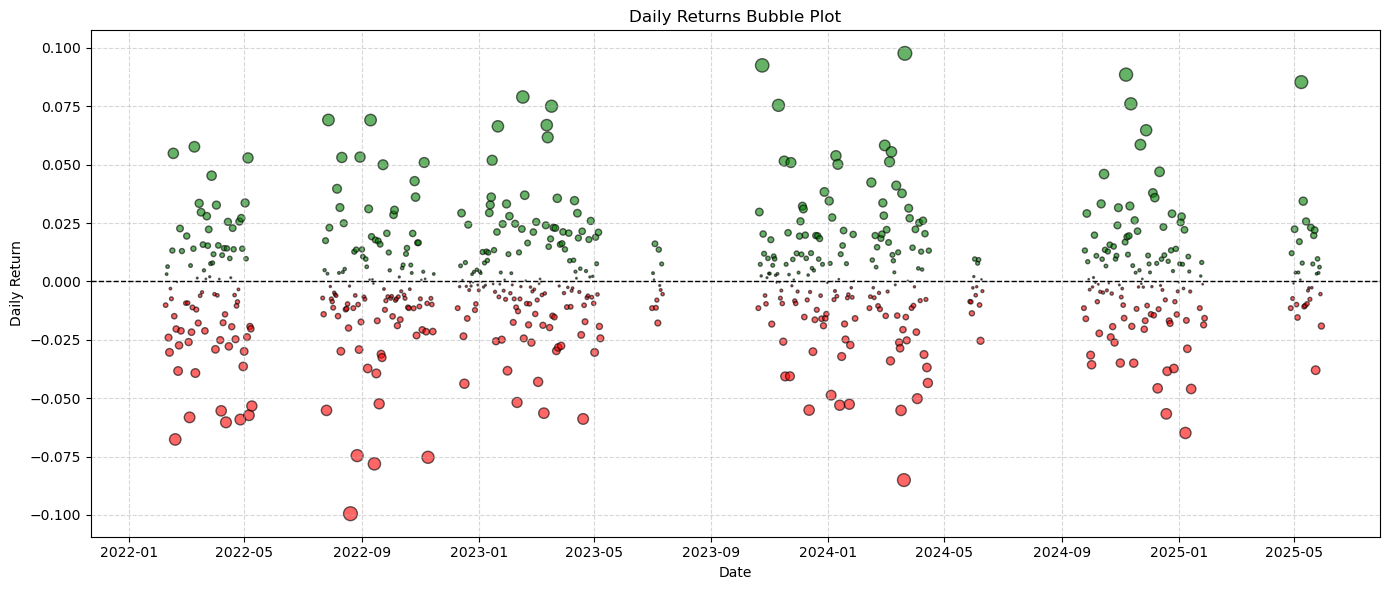

In [148]:
perf.plot_daily_returns_bubble(df_moving_avg_performance_log_space_portfolio, return_col='portfolio_daily_pct_returns')

In [102]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_sol, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.05697443905918553,
 'annualized_sharpe_ratio': 0.26520213423263483,
 'calmar_ratio': 0.09340271490731322,
 'annualized_std_dev': 0.881469540272362,
 'max_drawdown': -0.6099869700331865,
 'max_drawdown_duration': Timedelta('271 days 00:00:00'),
 'hit_rate': 0.23616236162361623,
 't_statistic': 0.4412941666790647,
 'p_value': 0.6591763594205207,
 'trade_count': 121.0}

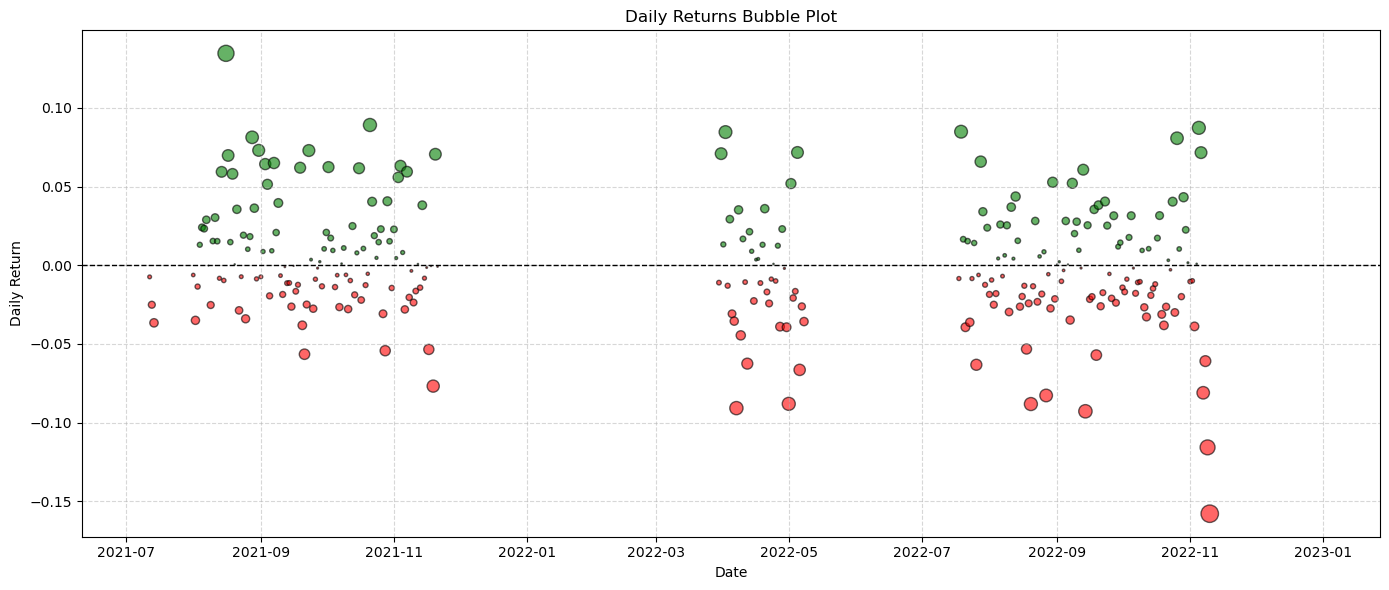

In [104]:
perf.plot_daily_returns_bubble(df_moving_avg_performance_log_space_sol, return_col='portfolio_daily_pct_returns')

In [98]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_eth, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.48697922902681,
 'annualized_sharpe_ratio': 0.9716272955748352,
 'calmar_ratio': 0.8424854863791119,
 'annualized_std_dev': 0.9113745001009231,
 'max_drawdown': -0.5780268466342139,
 'max_drawdown_duration': Timedelta('679 days 00:00:00'),
 'hit_rate': 0.24286912751677853,
 't_statistic': 2.747880820031612,
 'p_value': 0.00604335307248447,
 'trade_count': 459.0}

In [79]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6582111636418206,
 'annualized_sharpe_ratio': 1.321484003129544,
 'calmar_ratio': 1.2110044268524596,
 'annualized_std_dev': 0.848803663332553,
 'max_drawdown': -0.5435249855796048,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30796529968454256,
 't_statistic': 3.798155964754949,
 'p_value': 0.00014920125426481302,
 'trade_count': 381.0}

In [57]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 90
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.42580338892461134,
 'annualized_sharpe_ratio': 0.9532421451224398,
 'calmar_ratio': 0.8220365132166283,
 'annualized_std_dev': 0.8539778929772243,
 'max_drawdown': -0.5179859800368757,
 'max_drawdown_duration': Timedelta('417 days 00:00:00'),
 'hit_rate': 0.2910094637223975,
 't_statistic': 2.828192433106965,
 'p_value': 0.004717938687789893,
 'trade_count': 361.0}

In [52]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 90
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6676726791604137,
 'annualized_sharpe_ratio': 1.337697235909859,
 'calmar_ratio': 1.2960851340506159,
 'annualized_std_dev': 0.8452697660537717,
 'max_drawdown': -0.5151456965436803,
 'max_drawdown_duration': Timedelta('512 days 00:00:00'),
 'hit_rate': 0.3055993690851735,
 't_statistic': 3.8416844882688377,
 'p_value': 0.00012519063344396252,
 'trade_count': 378.0}

In [47]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5620084786981654,
 'annualized_sharpe_ratio': 1.1676131222630706,
 'calmar_ratio': 1.1564919879019482,
 'annualized_std_dev': 0.8718075671561296,
 'max_drawdown': -0.4859596820188387,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.30165615141955837,
 't_statistic': 3.389221077045426,
 'p_value': 0.000711633810553895,
 'trade_count': 379.0}

In [63]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6830040169904716,
 'annualized_sharpe_ratio': 1.3577436503012106,
 'calmar_ratio': 1.2342827467319515,
 'annualized_std_dev': 0.8395080255171072,
 'max_drawdown': -0.5533610664160076,
 'max_drawdown_duration': Timedelta('544 days 00:00:00'),
 'hit_rate': 0.3032334384858044,
 't_statistic': 3.893754936930333,
 'p_value': 0.00010125339237493625,
 'trade_count': 382.0}

In [67]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7177303189832578,
 'annualized_sharpe_ratio': 1.412434962267766,
 'calmar_ratio': 1.5102446188126237,
 'annualized_std_dev': 0.8535618257704096,
 'max_drawdown': -0.47524110335685077,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.3055993690851735,
 't_statistic': 4.039321725402911,
 'p_value': 5.5199021263409285e-05,
 'trade_count': 370.0}

In [266]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [262]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [241]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [247]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 252
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5601896774222164,
 'annualized_sharpe_ratio': 1.195784675674926,
 'calmar_ratio': 1.154511617945539,
 'annualized_std_dev': 0.8535506710292751,
 'max_drawdown': -0.4852178780314723,
 'max_drawdown_duration': Timedelta('512 days 00:00:00'),
 'hit_rate': 0.2917981072555205,
 't_statistic': 3.4762539969178783,
 'p_value': 0.0005170206773485146,
 'trade_count': 363.0}

In [237]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 180
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6814141881754403,
 'annualized_sharpe_ratio': 1.3697858916106793,
 'calmar_ratio': 1.4237354316198378,
 'annualized_std_dev': 0.8409866281300948,
 'max_drawdown': -0.4786101216854381,
 'max_drawdown_duration': Timedelta('508 days 00:00:00'),
 'hit_rate': 0.29337539432176657,
 't_statistic': 3.9301447833583967,
 'p_value': 8.716637193469062e-05,
 'trade_count': 367.0}

In [218]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [215]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.622702967574905,
 'annualized_sharpe_ratio': 1.2633326410728607,
 'calmar_ratio': 1.0249745800955936,
 'annualized_std_dev': 0.852553098199707,
 'max_drawdown': -0.6075301570082148,
 'max_drawdown_duration': Timedelta('551 days 00:00:00'),
 'hit_rate': 0.30441640378548895,
 't_statistic': 3.6430099883854843,
 'p_value': 0.00027487355988600054,
 'trade_count': 378.0}

## Run Walk Forward Analysis for Moving Average Crossover Signal

In [373]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

In [163]:
import itertools

def generate_moving_avg_ribbon_params():
    parameter_grid = {
        "fast_window": [8, 10, 12, 14, 16, 18, 20],
        "slow_fast_ratio":     [4, 6, 8, 10, 12, 14, 16],
        "stepsize":     [2, 4, 6, 8],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [329]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','MATIC-USD','ADA-USD']
df_portfolio_test = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2017-01-01').date(), end_date=pd.Timestamp('2020-12-31').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

BTC-USD
ETH-USD


In [365]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'MATIC-USD', 'ADA-USD']

In [367]:
end_date

datetime.date(2022, 12, 31)

In [369]:
## Check if data is available for all the tickers
date_list = cn.coinbase_start_date_by_ticker_dict
ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < pd.Timestamp('2020-12-31').date()]

for ticker in ticker_list:
    print(ticker)
    df_portfolio_test[f'{ticker}_daily_pnl'] = (df_portfolio_test[f'{ticker}_actual_position_size'] * df_portfolio_test[f'{ticker}_open'].diff().shift(-1))
    df_portfolio_test[f'{ticker}_daily_pct_returns'] = (df_portfolio_test[f'{ticker}_daily_pnl'] / df_portfolio_test[f'total_portfolio_value'].shift(1)).fillna(0)
    df_portfolio_test[f'{ticker}_position_count'] = np.where((df_portfolio_test[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate

BTC-USD
ETH-USD


In [361]:
df_portfolio_test[df_portfolio_test[f'{ticker}_actual_position_notional'] != 0].shape

(811, 66)

In [375]:
df_portfolio_test = calculate_asset_level_returns(df_portfolio_test, pd.Timestamp('2020-12-31').date(), ticker_list)

In [167]:
for params in generate_moving_avg_ribbon_params():
    print(params)

{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 2}
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 4}
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 6}
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 8}
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 2}
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 4}
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 6}
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 8}
{'fast_window': 8, 'slow_fast_ratio': 8, 'stepsize': 2}
{'fast_window': 8, 'slow_fast_ratio': 8, 'stepsize': 4}
{'fast_window': 8, 'slow_fast_ratio': 8, 'stepsize': 6}
{'fast_window': 8, 'slow_fast_ratio': 8, 'stepsize': 8}
{'fast_window': 8, 'slow_fast_ratio': 10, 'stepsize': 2}
{'fast_window': 8, 'slow_fast_ratio': 10, 'stepsize': 4}
{'fast_window': 8, 'slow_fast_ratio': 10, 'stepsize': 6}
{'fast_window': 8, 'slow_fast_ratio': 10, 'stepsize': 8}
{'fast_window': 8, 'slow_fast_ratio': 12, 'stepsize': 2}
{'fast_window': 8, 'slow_fast_ratio': 12, '

In [339]:
def run_walk_forward_moving_avg_ribbon(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'portfolio/ticker', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(start_date_is, end_date_is, start_date_os, end_date_os)
        if end_date_os > end_date:
            break
    
        # for params in generate_rolling_r_sqr_params():
        #     print(params)
        #     fast_mavg = params['fast_window']
        #     slow_mavg = params['slow_fast_ratio'] * fast_mavg
        #     mavg_stepsize = params['stepsize']
        #     print(fast_mavg, slow_mavg, mavg_stepsize)
            # df_is = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
            #     start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            #     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
            #     donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
            #     r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
            #     long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
            #     volatility_window=volatility_window, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            #     transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            #     rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
            #     annualized_target_volatility=annualized_target_volatility, annual_trading_days=annual_trading_days, 
            #     use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            # df_os = apply_target_volatility_position_sizing_continuous_strategy_rolling_r2(
            #     start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            #     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
            #     donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
            #     r2_window=r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
            #     long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
            #     volatility_window=volatility_window, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            #     transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            #     rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
            #     annualized_target_volatility=annualized_target_volatility, annual_trading_days=annual_trading_days, 
            #     use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            # performance_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
            #                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
            #                                                                 passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            # performance_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
            #                                                                 strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
            #                                                                 passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            # row_is = {
            #     'sampling_category': 'in_sample',
            #     'start_date': start_date_is,
            #     'end_date': end_date_is,
            #     'r2_window': r2_window,
            #     'lower_r_sqr_limit': lower_r_sqr_limit,
            #     'upper_r_sqr_limit': upper_r_sqr_limit,
            #     'annualized_return': performance_metrics_is['annualized_return'],
            #     'sharpe_ratio': performance_metrics_is['annualized_sharpe_ratio'],
            #     'calmar_ratio': performance_metrics_is['calmar_ratio'],
            #     'annualized_std_dev': performance_metrics_is['annualized_std_dev'],
            #     'max_drawdown': performance_metrics_is['max_drawdown'],
            #     'max_drawdown_duration': performance_metrics_is['max_drawdown_duration'],
            #     'hit_rate': performance_metrics_is['hit_rate'],
            #     't_statistic': performance_metrics_is['t_statistic'],
            #     'p_value': performance_metrics_is['p_value'],
            #     'trade_count': performance_metrics_is['trade_count']
            # }
            # row_os = {
            #     'sampling_category': 'out_sample',
            #     'start_date': start_date_os,
            #     'end_date': end_date_os,
            #     'r2_window': r2_window,
            #     'lower_r_sqr_limit': lower_r_sqr_limit,
            #     'upper_r_sqr_limit': upper_r_sqr_limit,
            #     'annualized_return': performance_metrics_os['annualized_return'],
            #     'sharpe_ratio': performance_metrics_os['annualized_sharpe_ratio'],
            #     'calmar_ratio': performance_metrics_os['calmar_ratio'],
            #     'annualized_std_dev': performance_metrics_os['annualized_std_dev'],
            #     'max_drawdown': performance_metrics_os['max_drawdown'],
            #     'max_drawdown_duration': performance_metrics_os['max_drawdown_duration'],
            #     'hit_rate': performance_metrics_os['hit_rate'],
            #     't_statistic': performance_metrics_os['t_statistic'],
            #     'p_value': performance_metrics_os['p_value'],
            #     'trade_count': performance_metrics_os['trade_count']
            # }
            # df_performance = pd.concat([df_performance, pd.DataFrame([row_is])], ignore_index=True)
            # df_performance = pd.concat([df_performance, pd.DataFrame([row_os])], ignore_index=True)
    
        start_date_is = (start_date_is + OS_LEN).date()

    return df_performance

In [347]:
run_walk_forward_moving_avg_ribbon(start_date='2021-06-01', end_date='2025-06-30', ticker_list=ticker_list)

2021-06-01 2023-05-31 2023-06-01 2023-11-30
2021-12-01 2023-11-30 2023-12-01 2024-05-31
2022-06-01 2024-05-31 2024-06-01 2024-11-30
2022-12-01 2024-11-30 2024-12-01 2025-05-31
2023-06-01 2025-05-31 2025-06-01 2025-11-30


,sampling_category,portfolio/ticker,start_date,end_date,fast_mavg,slow_mavg,mavg_stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count


In [191]:
df_trend_log = generate_trend_signal_with_donchian_channel_continuous(
    start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=10, slow_mavg=60,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
    ma_crossover_signal_weight=ma_crossover_signal_weight, 
    price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)

In [195]:
df_trend_log.head(200)

,BTC-USD_close,BTC-USD_open,BTC-USD_close_log,BTC-USD_8_ema,BTC-USD_16_ema,BTC-USD_32_ema,BTC-USD_64_ema,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank,BTC-USD_20_donchian_upper_band_price_t_2,BTC-USD_20_donchian_lower_band_price_t_2,BTC-USD_20_donchian_middle_band_price_t_2,BTC-USD_20_donchian_binary_signal,BTC-USD_donchian_continuous_signal,BTC-USD_donchian_continuous_signal_rank,BTC-USD_final_weighted_additive_signal,BTC-USD_activation,BTC-USD_final_signal
date,,,,,,,,,,,,,,,,,,
2016-01-01,435.66,430.35,6.076862,6.076862,6.076862,6.076862,6.076862,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-02,435.40,435.67,6.076265,6.076729,6.076792,6.076826,6.076844,3.263626e-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-03,431.91,435.40,6.068217,6.074838,6.075783,6.076304,6.076578,5.437940e-05,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.85,431.90,6.072699,6.074363,6.075420,6.076086,6.076459,8.284672e-04,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-05,433.34,433.84,6.071523,6.073731,6.074962,6.075809,6.076307,1.003357e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-06,430.87,433.32,6.065806,6.071970,6.073885,6.075203,6.075984,1.237014e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-07,459.07,430.66,6.129203,6.084689,6.080393,6.078476,6.077621,1.927333e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-08,454.44,459.07,6.119066,6.092328,6.084942,6.080936,6.078897,-3.335290e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-09,450.38,454.41,6.110092,6.096275,6.087901,6.082703,6.079857,-6.391252e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [199]:
df_trend_log[f'{ticker}_mavg_ribbon_rank'].shift(1).corr(df_trend_log[f'{ticker}_close'].pct_change())

-0.036030216396306006

<Axes: xlabel='date'>

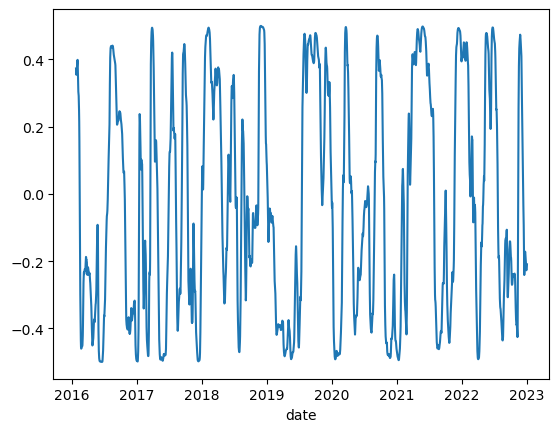

In [201]:
df_trend_log[f'{ticker}_final_weighted_additive_signal'].plot()

<Axes: xlabel='date'>

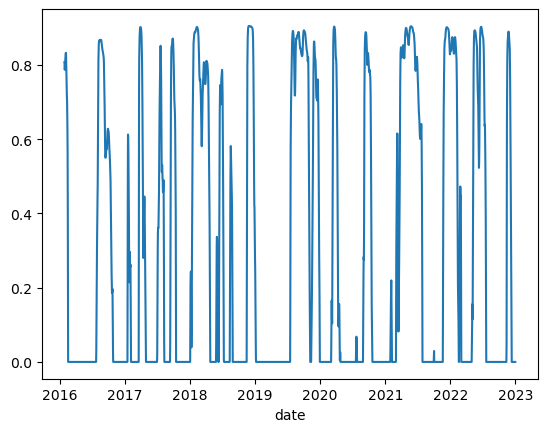

In [205]:
df_trend_log[f'{ticker}_final_signal'].plot()

<Axes: xlabel='date'>

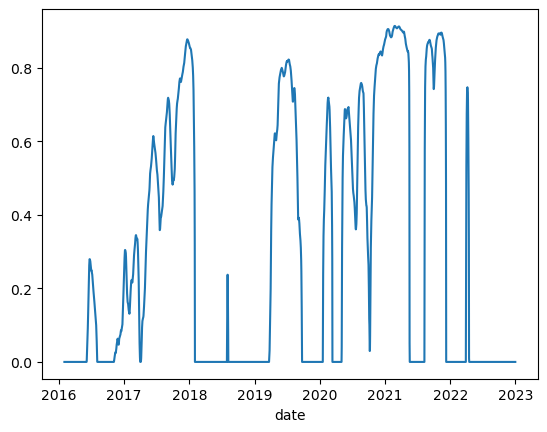

In [207]:
df_moving_avg_performance_orig[f'{ticker}_final_signal'].plot()

In [48]:
# ---- constants ----
windows = 2**np.arange(np.log2(10), np.log2(60)+0.01, 0.5).round().astype(int)   # e.g. 10,14,20,28,40,56
x       = np.log(windows)
xm      = x - x.mean()
varx    = (xm**2).sum()

In [50]:
windows

array([ 8, 16, 16, 32, 32, 64])

In [146]:
np.geomspace(fast_mavg, slow_mavg, num=6).round().astype(int)

array([10, 14, 20, 29, 42, 60])

In [52]:
x

array([2.07944154, 2.77258872, 2.77258872, 3.4657359 , 3.4657359 ,
       4.15888308])

In [56]:
# Pull Close Prices from Coinbase
ticker = ticker_list[0]
df_btc = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
df_btc = (df_btc[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
df_btc = df_btc[(df_btc.index.get_level_values('date') >= start_date) & (df_btc.index.get_level_values('date') <= end_date)]

In [118]:
mavg_start = 10
mavg_end = 60
log_step = 0.5

In [114]:
df_trend_btc = create_trend_strategy_log_space(df_btc, ticker='BTC-USD', mavg_start=10, mavg_end=60, log_step=0.5)

In [116]:
df_trend_btc.head(200)

,BTC-USD_close,BTC-USD_open,BTC-USD_8_ema,BTC-USD_16_ema,BTC-USD_32_ema,BTC-USD_64_ema,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank
date,,,,,,,,
2016-01-01,435.66,430.35,435.660000,435.660000,435.660000,435.660000,NaN,NaN
2016-01-02,435.40,435.67,435.602222,435.629412,435.644242,435.652000,-7.739074e-14,NaN
2016-01-03,431.91,435.40,434.781728,435.191834,435.417925,435.536862,2.347588e-02,NaN
2016-01-04,433.85,431.90,434.574678,435.033971,435.322899,435.484958,3.564219e-01,NaN
2016-01-05,433.34,433.84,434.300305,434.834680,435.202723,435.418959,4.339492e-01,NaN
2016-01-06,430.87,433.32,433.538015,434.368247,434.940134,435.278991,5.366890e-01,NaN
2016-01-07,459.07,430.66,439.211789,437.274336,436.402550,436.011022,8.350191e-01,NaN
2016-01-08,454.44,459.07,442.595836,439.293826,437.495729,436.578068,-1.488058e+00,NaN
2016-01-09,450.38,454.41,444.325650,440.598082,438.276594,437.002743,-2.839420e+00,NaN


In [70]:
# ---- constants ----
windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, mavg_stepsize).round().astype(int)   # e.g. 10,14,20,28,40,56
x       = np.log(windows)
xm      = x - x.mean()
varx    = (xm**2).sum()

# ---- compute MAs (vectorised) ----
for w in windows:
    df_btc[f'{ticker}_{w}_ema'] = df_btc[f'{ticker}_close'].ewm(span=w, adjust=False).mean()

mavg_mat = df_btc[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()

In [82]:
mavg_mat

array([[  435.66      ,   435.66      ,   435.66      ,   435.66      ,
          435.66      ,   435.66      ],
       [  435.60222222,   435.62941176,   435.62941176,   435.64424242,
          435.64424242,   435.652     ],
       [  434.7817284 ,   435.19183391,   435.19183391,   435.4179247 ,
          435.4179247 ,   435.53686154],
       ...,
       [16730.40134281, 16814.28226198, 16814.28226198, 16975.73708353,
        16975.73708353, 17522.40553273],
       [16701.44548885, 16789.0843488 , 16789.0843488 , 16952.97119968,
        16952.97119968, 17494.02690095],
       [16663.42426911, 16758.64501365, 16758.64501365, 16927.35779364,
        16927.35779364, 17464.375304  ]])

In [74]:
x

array([2.07944154, 2.77258872, 2.77258872, 3.4657359 , 3.4657359 ,
       4.15888308])

In [76]:
xm

array([-1.03972077, -0.34657359, -0.34657359,  0.34657359,  0.34657359,
        1.03972077])

In [78]:
varx

2.6424915765501074

In [68]:
df_btc.head()

,BTC-USD_close,BTC-USD_open
date,,
2016-01-01,435.66,430.35
2016-01-02,435.40,435.67
2016-01-03,431.91,435.40
2016-01-04,433.85,431.90
2016-01-05,433.34,433.84


In [ ]:

# ---- slope (vectorised) ----
slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead

# ---- z-score & rank ----
z      = (slope - slope.rolling(252).mean()) / slope.rolling(252).std()
rank   = scipy.stats.norm.cdf(z).sub(0.5)              # centred 0↔±0.5

df_trend[trend_continuous_signal_col]      = slope
df_trend[trend_continuous_signal_rank_col] = rank